In [1]:
import torch
import torchvision
print(torchvision.__version__)

0.23.0+cu126


In [2]:
try:
  from torchinfo import summary
except:
  !pip install -q torchinfo
  from torchinfo import summary


try :
  from going_modular.going_modular import data_setup, engine
except:
  print("[INFO] Couldn't find going_modular scripts ... downloading then from GIthub")
  !git clone https://github.com/mrdbourke/pytorch-deep-learning
  !mv pytorch-deep-learning/going_modular .
  !rm -rf pytorch-deep-learning
  from going_modular.going_modular import data_setup, engine

[INFO] Couldn't find going_modular scripts ... downloading then from GIthub
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 4393, done.
remote: Total 4393 (delta 0), reused 0 (delta 0), pack-reused 4393 (from 1)
Receiving objects: 100% (4393/4393), 764.14 MiB | 36.74 MiB/s, done.
Resolving deltas: 100% (2657/2657), done.
Updating files: 100% (248/248), done.


In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [4]:
#1. Get data
import os
import zipfile

from pathlib import Path
import requests

data_path = Path("data/")
image_path = data_path/ "pizza_steak_sushi"

#if the image folder doesnt exis
if image_path.is_dir():
  print("path exists skinng redownload")
else:
  print(f" did not find")
  image_path.mkdir(parents=True, exist_ok=True)

with open(data_path/"pizza_steak_sushi.zip", "wb") as f:
  request= requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/refs/heads/main/data/pizza_steak_sushi.zip")
  print(" doenloading the data")
  f.write(request.content)

with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
  print("Unzipping pizza , steak , sushi data ...")
  zip_ref.extractall(image_path)

os.remove(data_path / "pizza_steak_sushi.zip")




 did not find
 doenloading the data
Unzipping pizza , steak , sushi data ...


In [5]:
train_dir = image_path /"train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

In [6]:
from torchvision import transforms
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
manual_transforms = transforms.Compose([transforms.Resize((224,224)),
                                     transforms.ToTensor(),
                                      normalize])


## create loaders

In [7]:


train_dataloader, test_dataloader, class_names= data_setup.create_dataloaders(train_dir,test_dir, transform=manual_transforms, batch_size=32)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7dab51a9f740>,
 ['pizza', 'steak', 'sushi'])

In [8]:
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
weights

EfficientNet_B0_Weights.IMAGENET1K_V1

In [9]:
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [10]:
train_dataloader , test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir, test_dir=test_dir,transform=auto_transforms,batch_size=32)
train_dataloader,test_dataloader,class_names

(<torch.utils.data.dataloader.DataLoader at 0x7dab51b50710>,
 ['pizza', 'steak', 'sushi'])

##3. Getting a pretrained model
there are vario to get a pretrained models,
1. Pytoch domain linraries
2. Libraries like `timm`
3. HUgging face
4. Paperswith code

###3.1 try and findout which trained model. "Experiment, experiment, Experiment!*"
thinggs to be consider
1. speed
2. size
3. Perfomance


In [11]:
##PReatrained model
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
model = torchvision.models.efficientnet_b0(weights=weights).to(device)
model

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth


100%|██████████| 20.5M/20.5M [00:00<00:00, 88.9MB/s]


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [12]:
#print summar
from torchinfo import summary
summary(model=model,
        input_size=(1,3,224,224),
        col_names=["input_size", "output_size","num_params", "trainable"],
        row_settings=["var_names"],
        col_width=25)

Layer (type (var_name))                                      Input Shape               Output Shape              Param #                   Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]          [1, 1000]                 --                        True
├─Sequential (features)                                      [1, 3, 224, 224]          [1, 1280, 7, 7]           --                        True
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]          [1, 32, 112, 112]         --                        True
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]          [1, 32, 112, 112]         864                       True
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]         [1, 32, 112, 112]         64                        True
│    │    └─SiLU (2)                                         [1, 32, 112, 112]         [1, 32, 112, 112]         --                

In [13]:
###Frezing the base model and change the out layer to suit the needs
for param in model.features.parameters():
  param.requires_grad=False


In [14]:
summary(model=model,
        input_size=(1,3,224,224),
        col_names=["input_size", "output_size","num_params", "trainable"],
        row_settings=["var_names"],
        col_width=25)

Layer (type (var_name))                                      Input Shape               Output Shape              Param #                   Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]          [1, 1000]                 --                        Partial
├─Sequential (features)                                      [1, 3, 224, 224]          [1, 1280, 7, 7]           --                        False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]          [1, 32, 112, 112]         --                        False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]          [1, 32, 112, 112]         (864)                     False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]         [1, 32, 112, 112]         (64)                      False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]         [1, 32, 112, 112]         --         

In [15]:
from torch import nn

torch.manual_seed(42)
torch.cuda.manual_seed(42)

model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features= 1280, out_features=len(class_names)))
model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=3, bias=True)
)

###Train Model


In [16]:
#loss and optimizer
loss_fn= nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(params=model.parameters(), lr =0.001)

In [17]:
from going_modular.going_modular import engine

torch.manual_seed(42)
torch.cuda.manual_seed(42)

from timeit import default_timer as timer

start_time = timer()
#Setup train

results = engine.train(model = model,
                       train_dataloader = train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=5,
                       device=device)
end_time = timer()
print(f"[INFO] Total training time:{end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0924 | train_acc: 0.3984 | test_loss: 0.9133 | test_acc: 0.5398
Epoch: 2 | train_loss: 0.8717 | train_acc: 0.7773 | test_loss: 0.7912 | test_acc: 0.8153
Epoch: 3 | train_loss: 0.7648 | train_acc: 0.7930 | test_loss: 0.7463 | test_acc: 0.8561
Epoch: 4 | train_loss: 0.7109 | train_acc: 0.7539 | test_loss: 0.6373 | test_acc: 0.8655
Epoch: 5 | train_loss: 0.6255 | train_acc: 0.7852 | test_loss: 0.6261 | test_acc: 0.8561
[INFO] Total training time:14.753 seconds


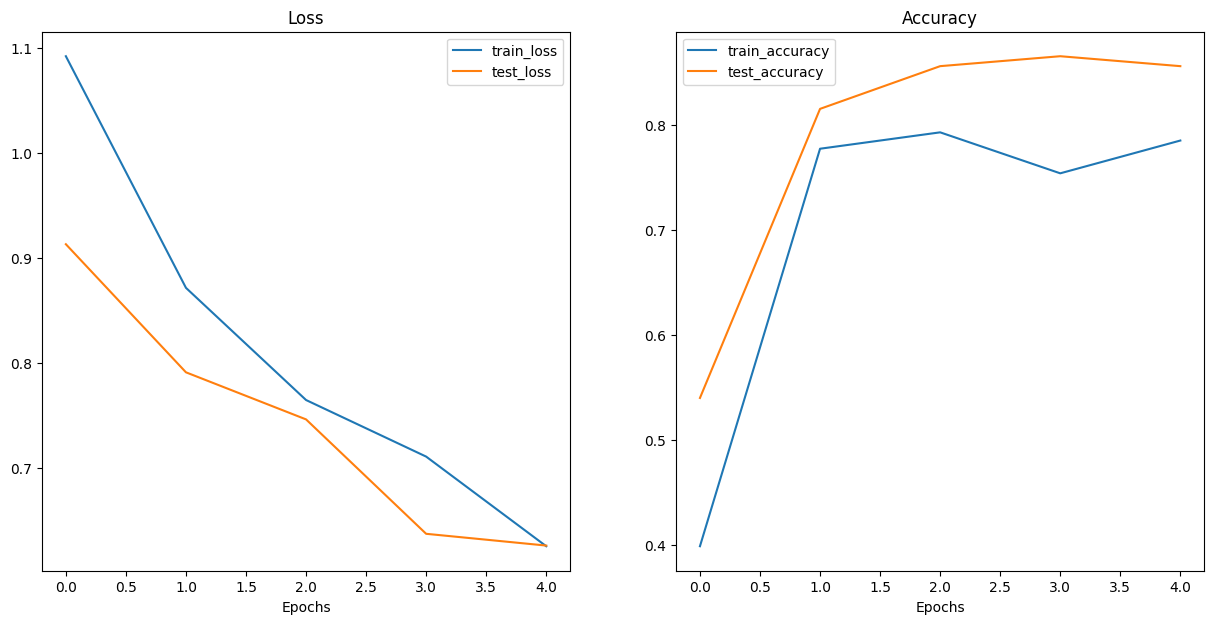

In [20]:
#plot curves
try:
  from helper_functions import plot_loss_curves
except:
  print(f"[INFO] COundn't find helper_functions.py, downloading..")
  with open("helper_functions.py", "wb") as f:
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
    f.write(request.content)
    from helper_functions import plot_loss_curves
plot_loss_curves(results)

## make prediction on custom data

In [33]:
from typing import List, Tuple
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms

def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str,
                        class_names: List[str],
                        image_size:Tuple[int,int] = (224,224),
                        transform: torchvision.transforms =None,
                        device : torch.device = device):
  img = Image.open(image_path)

  if transform is not None:
    image_transform= transform
  else:
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
    image_transform = transforms.Compose([transforms.Resize(image_size),
                                     transforms.ToTensor(),
                                      normalize])
    model.to(device)

    #5 . Turn on inference model and eval model
    model.eval()
    with torch.inference_mode():
      transformed_image = image_transform(img).unsqueeze(dim=0).to(device)

      target_image_pred= model(transformed_image)

      pred_probs= torch.softmax(target_image_pred,dim=1)

      target_pred_label = torch.argmax(pred_probs, dim=1)

      plt.figure()
      plt.imshow(img)
      plt.title(f" Pred: {class_names[target_pred_label]}  | Prob: {pred_probs.max()}")
      plt.axis("off")



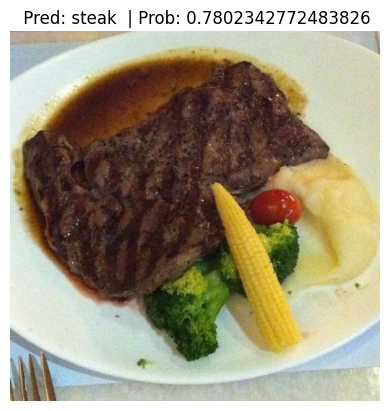

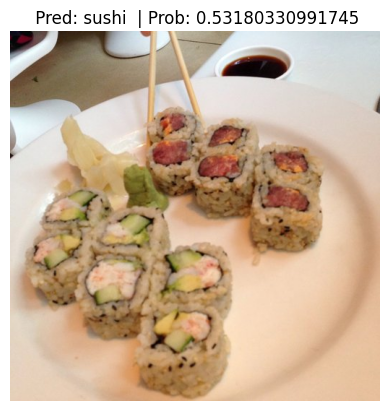

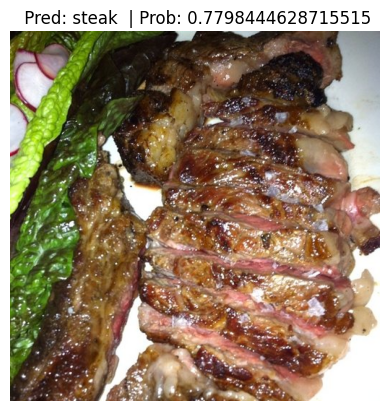

In [37]:
import random
torch.cuda.manual_seed(42)
torch.manual_seed(42)
num_images=3
image_path_list = list(Path(test_dir).glob("*/*.jpg"))
test_image_sample=random.sample(population = image_path_list, k=num_images)
for image_pth in test_image_sample:
  pred_and_plot_image(model=model,image_path=image_pth,
                      class_names=class_names,device=device)





In [39]:
import requests
custom_image_path = data_path / "04-pizza-dad.jpeg"

if not custom_image_path.is_file():
  with open(custom_image_path,"wb") as f:
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/af6548e52663c8395fe2777bd0fbfd6ac85fd6f8/images/04-pizza-dad.jpeg")
    f.write(request.content)
else:
  print("path exists skipinng download...")


path exists skipinng download...


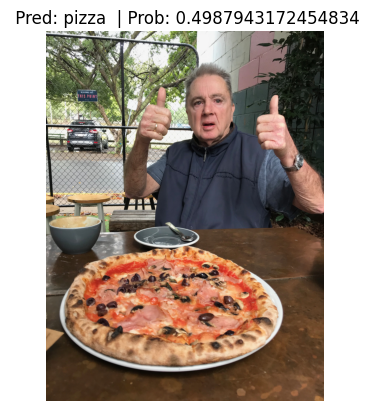

In [41]:
#Predict on cusom image
pred_and_plot_image(model=model,
                    image_path=custom_image_path,
                    class_names=class_names)